## Accurate Uncertainties for Deep Learning Using Calibrated Regression

**Authors**: *Anthony Rentsch* and *Abhimanyu Vasishth*

This notebook contains an implementation and overview of the [2018 paper](https://arxiv.org/abs/1807.00263) by Kuleshov et al.

---

### Table of Contents

1. [Prolem Statement](#problem_statement)
2. [Background](#background)
3. [Existing work](#existing_work)
4. [Contribution](#contribution)
5. [Technical Content](#technical_content)
6. [Experiments](#experiments)
7. [Evaluation](#evaluation)
8. [Future work](#future_work)
9. [Code](#code)
10. [References](#references)

<a id='problem_statement'></a>
#### Problem Statement 

what is the problem the paper aims to solve?

---

It is often desirable in statistical modeling and machine learning to obtain accurate estimates of the uncertainty associated with predictions, especially when these models are used in highly sensitive decision-making contexts. What are accurate estimates of uncertainty? One useful criteria is known as **calibration**. Consider these two motivation examples:

- In the classification setting, if we predict that an individual will exhibit some behavior with 30% probability it would be desirable for the long-term frequency of this individual exhibiting this behavior to actually be 30%.
- In the regression setting, it would be desirable for a 95% predictive interval to actually contain the true outcome 95% of the time.

If we meet this criteria in either setting, we would call our predictions **well-calibrated**. However, many types of algorithms do not produce well-calibrated predictions out-of-the-box. Since this is mostly a solved problem in classification, this paper provides a model-agnostic algorithm to calibrating credible intervals in regression. 

---

<a id='background'></a>
#### Background 

why is this problem important or interesting?

---

When do we want calibration?
- When model outputs being used for highly sensitive decision-making/planning, e.g., effects of drugs or public policies

When we don't care about calibration as much?
- When we just need to prioritize certain cases, so we just need rank-ordering


---

<a id='existing_work'></a>
#### Existing work 

what has been done in literature?

<a id='contribution'></a>
#### Contribution 

what is gap in literature that the paper is trying to fill? What is the unique contribution

<a id='technical_content'></a>
#### Technical content 

high level - what are the high level ideas behind their technical contribution
details - highlight (not copy and paste entire sections) the relevant details that are important to focus on (e.g. if there's a model, define it; if there is a theorem, state it and explain why it's important, etc).

![Sketch of algorithm](images/regression_cdf_plot.png)

<a id='experiments'></a>
#### Experiments 

which types of experiments were performed? What claims were these experiments trying to prove? Did the results prove the claims?

<a id='evaluation'></a>
#### Evaluation 

(your opinion) - do you think the work is technically sound? Do you think the proposed model/inference method is practical to use on real data and tasks? Do you think the experimental section was strong (there are sufficient evidence to support the claims and eliminate confounding factors)?

<a id='future_work'></a>
#### Future work 

(for those interested in continuing research in a related field) - do you think you can suggest a concrete change or modification that would improve the existing solution(s) to the problem of interest? Try to implement some of these changes/modifications.

---

how to make sharp intervals as well as calibrated ones

---

<a id='code'></a>
#### Code

- At least one clear working pedagogical example demonstrating the problem the paper is claiming to solve. 
- At lease a bare bones implementation of the model/algorithm/solution (in some cases, you may be able to make assumptions  to simplify the model/algorithm/solution with the approval of your instructor)
- Demonstration on at least one instance that your implementation solves the problem.
- Demonstration on at least one instance the failure mode of the model/algorithm/solution, with an explanation for why failure occurred (is the dataset too large? Did you choose a bad hyper parameter?). The point of this is to point out edge cases to the user.

In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.api import OLS

%matplotlib inline

### Regression - underlying trend is linear

In [2]:
# make data
n = 1000
X = np.linspace(-3,3,n)

y = 0.4*X + np.sin(4*X) + np.random.normal(0, 3, size=n) #+ X + X**2
# sort for plotting
indices = np.argsort(X.flatten())
X = X[indices]
y = y[indices]
# prepare for statsmodels
X_sm = sm.add_constant(-X**2 - X**4 + 10*X)

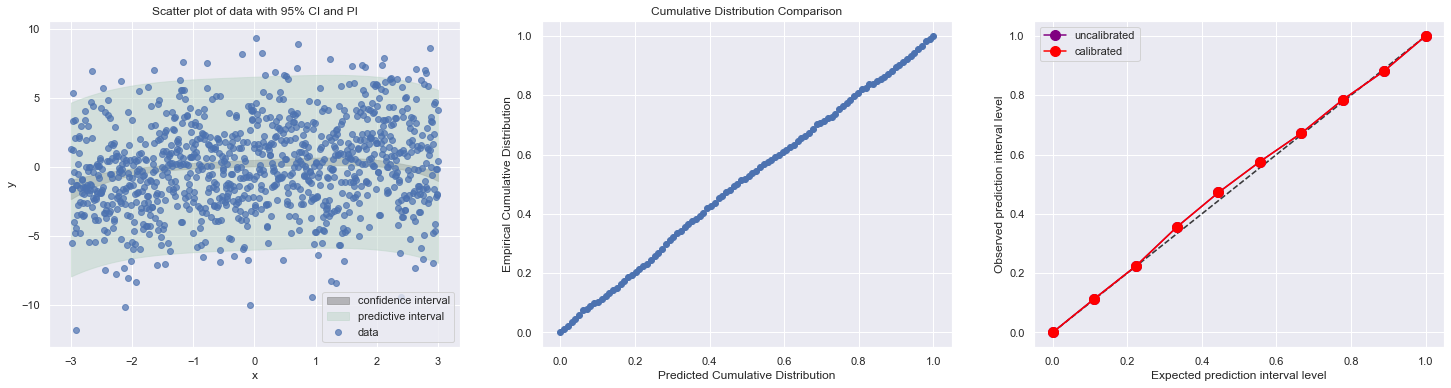

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(25,6))

# Figure 1
model = sm.OLS(y, X_sm).fit()
alpha = .95
fit = model.get_prediction().summary_frame(alpha=(1-alpha))
ax[0].fill_between(X.flatten(), fit['mean_ci_lower'], fit['mean_ci_upper'], 
                color='grey', alpha=0.5, label='confidence interval');
ax[0].fill_between(X.flatten(), fit['obs_ci_lower'], fit['obs_ci_upper'], 
                color='#BDD5C8', alpha=0.5, label='predictive interval')
ax[0].scatter(X.flatten(), y, alpha=0.7, label='data')
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title(f'Scatter plot of data with {int(alpha*100)}% CI and PI')

# Figure 2
alphas = np.linspace(0,1,100)
counts = []
for i, alpha in enumerate(alphas): # is this right???
    fit = model.get_prediction().summary_frame(alpha=(1-alpha))
    count = fit[(fit['obs_ci_lower'] < y) & (fit['obs_ci_upper'] > y)].shape[0]
    counts.append(count/n)
ax[1].plot(alphas, counts, 'o')
ax[1].set_xlabel('Predicted Cumulative Distribution')
ax[1].set_ylabel('Empirical Cumulative Distribution')
ax[1].set_title('Cumulative Distribution Comparison')

# Figure 3
alphas = np.linspace(0,1,10)
uncalibrated_props = []
for i, alpha in enumerate(alphas):
    fit = model.get_prediction().summary_frame(alpha=(1-alpha))
    count = fit[(fit['obs_ci_lower'] < y) & (fit['obs_ci_upper'] > y)].shape[0]
    uncalibrated_props.append(count/n)
ir = IsotonicRegression()
calibrated_props = ir.fit_transform(alphas, uncalibrated_props)
ax[2].plot([(0,0), (1,1)], color='black', linestyle='dashed', alpha=0.5)
ax[2].plot(alphas, uncalibrated_props, marker='o', markersize=10, linestyle='solid', color='purple', label='uncalibrated')
ax[2].plot(alphas, calibrated_props, marker='o', markersize=10, linestyle='solid', color='red', label='calibrated')
ax[2].legend()
ax[2].set_xlabel('Expected prediction interval level')
ax[2].set_ylabel('Observed prediction interval level');

In [4]:
h_xt_yt = st.norm.cdf(y, loc=fit['mean'], scale=fit['mean_se'])

In [5]:
P_hat = np.zeros(len(h_xt_yt))
for i, p in enumerate(h_xt_yt):
    P_hat[i] = np.sum(h_xt_yt <= p)/len(h_xt_yt)

In [6]:
ir = IsotonicRegression()
ir_preds = ir.fit_transform(h_xt_yt, P_hat)

In [7]:
for h, phat in zip(h_xt_yt, P_hat):
    print(h, phat)
    
# for h, p in zip(h_xt_yt, P_hat):
#     print(h, p)

0.9999999999999999 0.648
0.9626330311032166 0.54
0.5243929602675064 0.507
0.5352532007160629 0.508
3.3303808711075496e-30 0.314
1.0 1.0
0.9999999999999998 0.645
1.0 1.0
1.9926214382208407e-13 0.385
0.9998055953963385 0.567
1.0 1.0
1.0 1.0
2.498734279596358e-24 0.332
4.028832974907411e-223 0.101
1.6618305937293287e-20 0.344
0.7184692265431853 0.517
5.764581597009464e-11 0.398
0.6393962344033002 0.511
1.6469153478203234e-05 0.434
0.9999998970094903 0.595
0.9984836370840294 0.56
1.0 1.0
1.0 1.0
0.9999999999999992 0.641
0.33271013751300593 0.498
3.856748957026297e-31 0.311
3.3394367888252935e-05 0.437
1.0 1.0
5.704171471433602e-13 0.387
0.9413323853559711 0.536
0.024807618890448965 0.466
0.907038012835609 0.529
1.019273812137347e-06 0.424
0.23467176141863771 0.489
4.043562520595889e-16 0.368
0.0064101424389888095 0.458
6.301489292183262e-16 0.371
1.0 1.0
0.19637515436885133 0.486
1.0 1.0
0.9999977271728215 0.588
1.0 1.0
0.08859611448235505 0.478
2.9325630053822828e-08 0.412
0.3430110303103

---

In [136]:
# bootstrap when doing CDF

# create data
f = lambda x: 0.5*x + np.sin(0.3*x) + 4 + np.random.normal(0, 2, size=len(x))
X = np.concatenate([np.linspace(-10, -5, 300),
                         np.linspace(-5, 2, 50),
                         np.linspace(2, 10, 300)])
y = f(X)

X_eval = np.linspace(X.min(), X.max(), 200)
y_eval = f(X_eval)

In [137]:
# bootstrap when doing CDF
n_boots = 1000
poly_degree = 4

boot_preds = np.zeros(shape=(n_boots, len(X_eval)))

for i in range(n_boots):
    # bootstrap : X_, y_ = resample(X,y)
    inds = np.random.choice(range(X.shape[0]), size=X.shape[0])
    X_ = X[inds]
    y_ = y[inds]
    
    # instantiate model and feature preprocessing objects
    model = LinearRegression()
    poly = PolynomialFeatures(poly_degree)
    # preprocess data
    X_ = poly.fit_transform(X_.reshape(-1,1))
    # fit
    model.fit(X_, y_)
    # preprocess features to evaluate
    X_eval_ = poly.transform(X_eval.reshape(-1,1))
    # predict
    preds = model.predict(X_eval_)
    # store bootstrapped predictions
    boot_preds[i,:] = preds

X:  -6.884422110552764
y:  -5.566178058546214
y pred:  -0.14423948865471026
lower bound:  -0.38288380565274055
upper bound:  0.08433829571456398


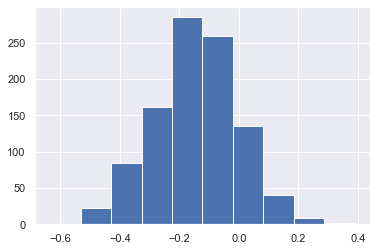

In [156]:
trial = 31
print('X: ', X_eval[trial])
print('y: ', y_eval[trial])
print('y pred: ', y_eval_preds[trial])
print('lower bound: ', lower_pi[trial])
print('upper bound: ', upper_pi[trial])
plt.hist(boot_preds[:,trial]);

In [138]:
# point estimate
model = LinearRegression()
poly = PolynomialFeatures(poly_degree)
X_ = poly.fit_transform(X.reshape(-1,1))
model.fit(X_, y)

X_eval_ = poly.transform(X_eval.reshape(-1,1))
y_eval_preds = model.predict(X_eval_)

# PI
lower_pi = np.percentile(boot_preds, 5, axis=0)
upper_pi = np.percentile(boot_preds, 95, axis=0)

In [139]:
# calibrate this now

#h_xt_yt = st.norm.cdf(y_eval, loc=model.predict(X_eval_), scale=np.std(boot_preds, axis=0))
h_xt_yt = np.mean(boot_preds <= y_eval_preds, axis=0)

P_hat = np.zeros(len(h_xt_yt))
for i, p in enumerate(h_xt_yt):
    P_hat[i] = np.sum(h_xt_yt <= p)/len(h_xt_yt)
    
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(h_xt_yt, P_hat)
#calibrated_preds = calibrator.predict(h_xt_yt)

# apply
new_quantiles = calibrator.transform([0.05, 0.95]) * 100
print(new_quantiles)
lower_pi_cal = np.percentile(boot_preds, new_quantiles[0], axis=0)
upper_pi_cal = np.percentile(boot_preds, new_quantiles[1], axis=0)

[  0.5 100. ]


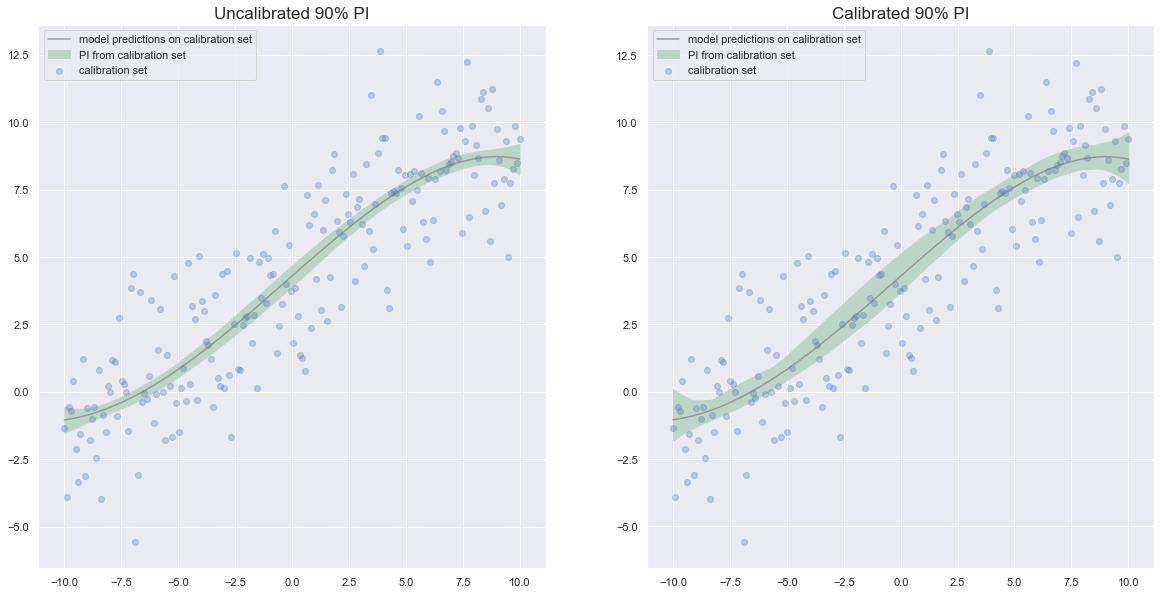

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].fill_between(X_eval, y1=lower_pi, y2=upper_pi, color='#BDD5C8', label='PI from calibration set')
ax[0].scatter(X_eval, y_eval, alpha=0.3, label='calibration set')
ax[0].plot(X_eval, y_eval_preds, color='grey', alpha=0.7, label='model predictions on calibration set')
ax[0].legend(loc='upper left')
ax[0].set_title('Uncalibrated 90% PI', fontsize=17)

ax[1].fill_between(X_eval, y1=lower_pi_cal, y2=upper_pi_cal, color='#BDD5C8', label='PI from calibration set')
ax[1].scatter(X_eval, y_eval, alpha=0.3, label='calibration set')
ax[1].plot(X_eval, y_eval_preds, color='grey', alpha=0.7, label='model predictions on calibration set')
ax[1].legend(loc='upper left')
ax[1].set_title('Calibrated 90% PI', fontsize=17);

In [132]:
results = pd.DataFrame.from_records({'X':X_eval,
                                     'y':y_eval,
                                     'h_xt_yt':h_xt_yt, 
                                     'P_hat':P_hat})[['X','y','h_xt_yt','P_hat',]]
results.head()

,X,y,h_xt_yt,P_hat
0,-10.000000,-2.201139,0.502,0.525
1,-9.899497,-0.871177,0.501,0.495
2,-9.798995,0.534920,0.500,0.465
3,-9.698492,1.406903,0.494,0.365
4,-9.597990,-2.753337,0.494,0.365


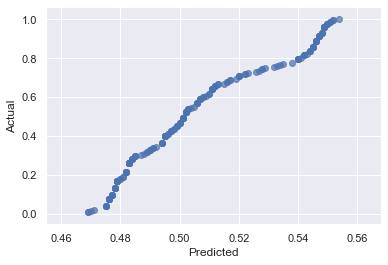

In [133]:
plt.scatter(h_xt_yt, P_hat, alpha=0.7)
plt.xlabel('Predicted')
plt.ylabel('Actual');

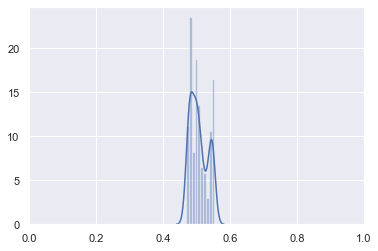

In [134]:
sns.distplot(h_xt_yt, bins=10, norm_hist=True)
plt.xlim([0,1]);

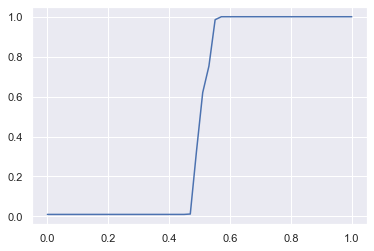

In [135]:
plt.plot(np.linspace(0,1,50), calibrator.predict(np.linspace(0,1,50)));

---

In [183]:
# bayesian model
import pymc3 as pm

In [251]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', mu=0, sigma=20)
    x = pm.Normal('x', mu=0, sigma=20, shape=2)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x[0] * X + x[1] * X**2, 
                           sigma=sigma, observed=y)

    # Inference!
    trace = pm.sample(3000, cores=2)
    
    pymc3_model = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:08<00:00, 831.25draws/s] 
The acceptance probability does not match the target. It is 0.9024881660137942, but should be close to 0.8. Try to increase the number of tuning steps.


In [252]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=pymc3_model)

100%|██████████| 500/500 [00:00<00:00, 674.42it/s]


In [253]:
intercept = np.mean(trace.get_values(varname='Intercept'))
x1,x2 = np.mean(trace.get_values(varname='x'), axis=0)
print(intercept, x1, x2)

point_estimates = intercept + x1*X + x2*X**2

ppc_interval = np.percentile(ppc['y'], [5, 95], axis=0)

4.420555030248204 0.5780850936299036 -0.005540853076562554


In [254]:
h_xt_yt = np.mean(point_estimates <= ppc['y'], axis=0)

P_hat = np.zeros(len(h_xt_yt))
for i, p in enumerate(h_xt_yt):
    P_hat[i] = np.sum(h_xt_yt <= p)/len(h_xt_yt)
    
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(h_xt_yt, P_hat)

# apply
new_quantiles = calibrator.transform([0.05, 0.95]) * 100
print(new_quantiles)
ppc_interval_cal = np.percentile(ppc['y'], [new_quantiles[0], new_quantiles[1]], axis=0)

[  0.15384615 100.        ]


In [255]:
perc_within_before = np.mean((y <= ppc_interval[1,:])*(y >= ppc_interval[0,:]))
within_before = f'{perc_within_before*100:.1f}% of the test points in the 90% PI'
print(within_before)

perc_within_after = np.mean((y <= ppc_interval_cal[1,:])*(y >= ppc_interval_cal[0,:]))
within_after = f'{perc_within_after*100:.1f}% of the test points in the 90% PI'
print(within_after)

90.6% of the test points in the 90% PI
99.7% of the test points in the 90% PI


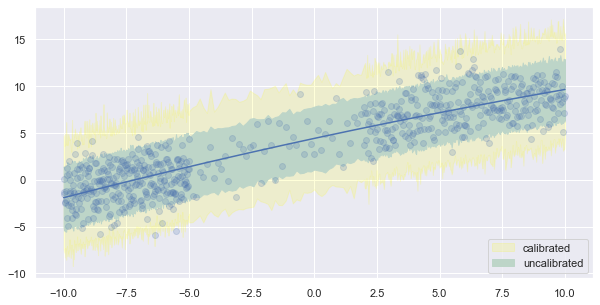

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(X, point_estimates)
ax.fill_between(X, y1=ppc_interval_cal[0,:], y2=ppc_interval_cal[1,:], color='yellow', alpha=0.15, label='calibrated')
ax.fill_between(X, y1=ppc_interval[0,:], y2=ppc_interval[1,:], color='#BDD5C8', label='uncalibrated')
ax.scatter(X, y, alpha=0.2)
ax.legend(loc='lower right');

---

In [160]:
from sklearn.model_selection import train_test_split

class CalibratedRegression:
    
    def __init__(self, X, y, model, cal_prop=0.2, cdf_method='bayesian'):
        self.X = X
        self.y = y
        self.model = model
        
        # split up training and calibration sets
        self.X_train, self.X_cal, self.y_train, self.y_cal = train_test_split(X, y, test_size=cal_prop)
        
        if cdf_method in ['bayesian','bootstrap','statsmodels']:
            self.cdf_method = cdf_method
        else:
            raise ValueError("cdf_method must be of type 'bayesian', 'bootstrap', or 'statsmodels'")
    
    def bootstrap():
        '''Utility function to bootstrap.'''
        pass
    
    def fit(self):
        '''Fit underlying model'''
        
        if self.cdf_method == 'bayesian':
            # get CDF from model output
            pass
        elif self.cdf_method == 'bootstrap':
            # get CDF from bootstrapping
            pass
        elif self.cdf_method == 'statsmodels':
            # get CDF from statsmodels 
            pass
    
    def predict():
        '''Return point estimates and PIs.'''
        # return y_pred, lower_PI, upper_PI
        pass
    
    def ecdf(self):
        '''Empirical CDF.'''
        pass
    
    def plot_calibration_curve(self):
        '''Plot calibration curve as described in paper.'''
        pass

<a id='references'></a>
#### References

[1]

---